In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from importer_snippets import make_ELISA_dataframe as ELISA_import

ModuleNotFoundError: No module named 'importer_snippets'

In [2]:
data_path = r'testdata_02192021_rhMMP9.txt' # Used Scan 2
with open(data_path) as file:
    lines = file.readlines()
    lines.pop(0)
    n = int((len(lines)) / 11)
    output_dataframes = []
    for i in range(n):
        df = ELISA_import(lines[11*i:11*i + 8])
        output_dataframes.append(df)
        
# Choose scan to use and do background subtraction
raw = output_dataframes[1].iloc[0:8, 0:8]
sub = raw.iloc[0:6, 0:8].sub(raw.iloc[6:8, 0:8].mean(axis=1).mean(axis=0))

In [3]:
# Reshape s.t. rows are replicants, the typical quadruplicant layout is below
reshape = sub.iloc[:, 4:8].rename(
    index={'A': 'I', 'B': 'J','C': 'K','D': 'L','E': 'M','F': 'N'}, 
    columns={5: 1, 6: 2, 7: 3, 8: 4})
data = sub.iloc[:, 0:4].append(reshape)

In [4]:
# Replace outliers with NaN
def grubbs_filter(data):
    '''
    This will be necessary, needs to replace any singular outlier with NaN
    '''
    pass

# the outlier I happen to have already found, write the function!
# data.iloc[2,3] = np.NaN

In [5]:
# Run stats
data['Mean'] = data.iloc[:,0:4].mean(axis=1)
data['SD'] = data.iloc[:, 0:4].std(ddof=1, axis=1)
data['Conc'] = {3500:'A',2500:'B',1500:'C',1000:'D',
                750:'E',500:'F',400:'I',300:'J',
                200:'K',100:'L',50:'M',25:'N'}

reg_x = data['Conc'].loc['F':'N'].values.reshape(-1,1)
reg_y = data['Mean'].loc['F':'N'].values.reshape(-1,1)
reg = LinearRegression().fit(reg_x, reg_y)

0.002637


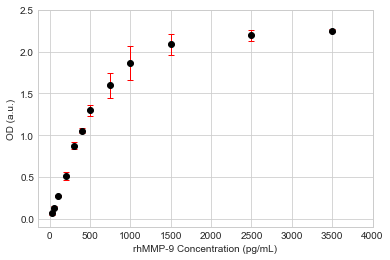

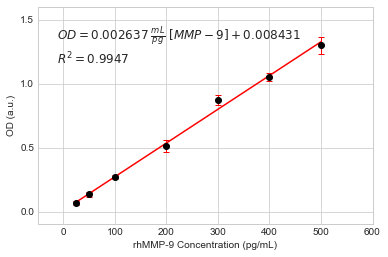

In [11]:
# Make plot
fig = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = fig.add_subplot(111)
ax.scatter(data['Conc'], data['Mean'], c='black', zorder=1)
ax.errorbar(data['Conc'], data['Mean'], data['SD'], linestyle='None', 
            elinewidth=1, c='red', capsize=3, capthick=1, zorder=0.9)
ax.set_ylabel('OD (a.u.)')
ax.set_xlabel('rhMMP-9 Concentration (pg/mL)')
ax.set_xlim([-150, 4000])
ax.set_ylim([-.1, 2.5])

# Make another showing linear fit
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.scatter(reg_x, reg_y, c='k', zorder=1)
ax2.plot(reg_x, reg.predict(reg_x), color='r', zorder=0.8)
ax2.errorbar(reg_x, reg_y, data['SD'].loc['F':'N'], linestyle='None', 
            elinewidth=1, c='red', capsize=3, capthick=1, zorder=0.9)

# Put the equation on the graph
text_slope, text_intercept = '$'+str(round(float(reg.coef_), 6))+'$', '$'+str(round(float(reg.intercept_), 6))+'$'
text_Rsquared = '$'+str(round(float(reg.score(reg_x, reg_y)), 4))+'$'
fig2.text(0.01, 0.9,
          r'$OD =$'
          + text_slope 
          + r'$\;\frac{mL}{pg}\;[MMP-9]+$' 
          + text_intercept + '\n'
          + r'$R^{2}=$' + text_Rsquared,
          horizontalalignment='left',
          size=12,
          verticalalignment='top',
          transform=ax.transAxes)

ax2.set_ylabel('OD (a.u.)')
ax2.set_xlabel('rhMMP-9 Concentration (pg/mL)')
ax2.set_yticks(np.arange(0, 1.7, .5))
ax2.set_xlim([-50, 600])
ax2.set_ylim([-.1, 1.6])